<a href="https://colab.research.google.com/github/ElmiraOn/P4-CRISTAL-Replication/blob/EECS6448_CRISTAL_suggestions/CRISTAL_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
!pip install translators

In [ ]:
!pip install langdetect

In [ ]:
!pip install emoji

In [ ]:
!pip install contractions

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download() ## select `all-nltk` and then download on jupyter note book

In [ ]:
pip install num2words

In [ ]:
pip install -U sentence-transformers

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from imblearn.under_sampling import RandomUnderSampler
import re
import string
import pickle
from emoji import EMOJI_DATA
import contractions
import nltk
from num2words import num2words
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time
from sklearn.model_selection import GridSearchCV # used for tuning algorithms and hyperparameters
from sklearn.svm import SVC
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem.porter import *
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

# Helper Functions

In [11]:
## replacing emojis with words
# 'Emoji_Dict.p'- download link https://drive.google.com/open?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v
with open('/content/drive/MyDrive/EECS6448/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

#example:
#convert_emojis_to_word("I like to eat 🍕") #--> I like to eat pizza

## convert emoticemoticons
# 'Emoticon_Dict.p'- download link https://drive.google.com/open?id=1HDpafp97gCl9xZTQWMgP2kKK_NuhENlE
with open('/content/drive/MyDrive/EECS6448/Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def convert_emoticons(text):
    for emot in Emoticon_Dict:
        text = re.sub(u'('+emot+')', "_".join(Emoticon_Dict[emot].replace(",","").split()), text)
    return text

In [12]:
# this function use to seperate number if they are attached to a word
def sep_num_words_func(text):
    return re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", text).strip()
# this function convert number to words
def num_to_words(text):
    text_sep = sep_num_words_func(text)
    after_spliting = text_sep.split()

    for index in range(len(after_spliting)):
        if after_spliting[index].isdigit():
            after_spliting[index] = num2words(after_spliting[index])
    numbers_to_words = ' '.join(after_spliting)
    return numbers_to_words

In [13]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

# A. Benchmarking AR miner

## Balancing Data

In [ ]:
def read_type_data():
    """
    Read data from the paper "Bug Report, Feature Request, or Simply Praise?" (Maalej & Nabil 2016)
    """
    cols = ['app', 'platform', 'pkg', 'id', 'lang', 'blank', 'type', 'date', 'user', 'title', 'User Review']
    data = pd.read_excel(Path('/content/drive/MyDrive/EECS6448/Informative_Training_Set.xlsx'), names=cols, header=None).drop('blank', axis=1)
    data['informative'] = data['type'].apply(lambda x: x <= 2)
    # data['Class'] = data['informative'].apply(lambda x: ['Informative'] if x else ['Non-informative'])
    data['User Review'] = data['User Review'].apply(lambda x: str(x))
    return data

df= read_type_data()


### Data Exploration

In [ ]:
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRUNyR05RcVZVV2t2ZzR0eXNpNTB2QXkwdz...,English,2,2016-08-05,Angie Martinez,New instagram,I hate the new instagram I don't see why gotta...,True
1,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRzhuenVHSUpsNGU3YVI1U3h5RVFETjJ2Y0...,English,5,2016-08-05,Emad Jadalla,So nice,I love it . So easy . Fabulous â™¥,False
2,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPR2c3UmI4VWFVWGhCMGI1VEowczQ3cGZtRF...,English,5,2016-08-05,Halie Godesky,Love it,Its great,False
3,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRTltSjhyd09zYk5vaVNFMldURHQwUzNxbU...,English,1,2016-08-05,Tamera Campbell,Update,"Please get rid of ""stories"" the video quality ...",True
4,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRmcwYjA3U1RBZl80MFV4WDFjX1JGeE1hWn...,English,4,2016-08-05,adam haris,nice app,good,False


In [ ]:
len(df)

8000

#### Removing NaN user review

In [ ]:
len(df[df["User Review"]=="nan" ])

34

<Axes: xlabel='informative', ylabel='count'>

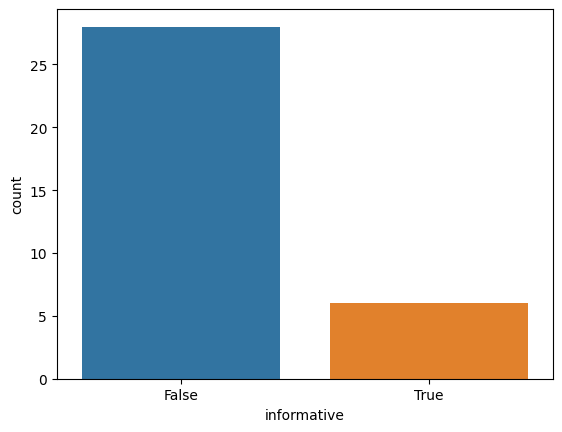

In [ ]:
d1 = df[df["User Review"]=="nan" ]
sns.countplot(x='informative', data=d1)

In [ ]:
df = df[df["User Review"]!="nan"]

In [ ]:
len(df)

7966

#### Balancing dataset by Random downsampling

<Axes: xlabel='informative', ylabel='count'>

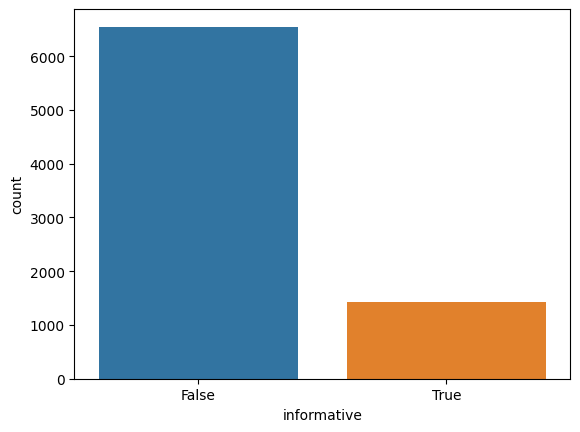

In [ ]:
sns.countplot(x='informative', data=df)

In [ ]:
num_false = len(df[df["informative"] == False])
num_true = len(df[df["informative"] == True])
print("There are "  +str(num_true) + " informative reviews. ")
print("There are "  +str(num_false) + " non-informative reviews. ")

There are 1419 informative reviews. 
There are 6547 non-informative reviews. 


We randomly downsample the "False" class using RandomUnderSampler method

In [ ]:
X=df.drop('informative',axis=1)
y=df['informative']
rus = RandomUnderSampler(sampling_strategy='not minority', random_state = 0)
X_res, y_res = rus.fit_resample(X, y)



In [ ]:
df = X_res
df["informative"] = y_res

<Axes: xlabel='informative', ylabel='count'>

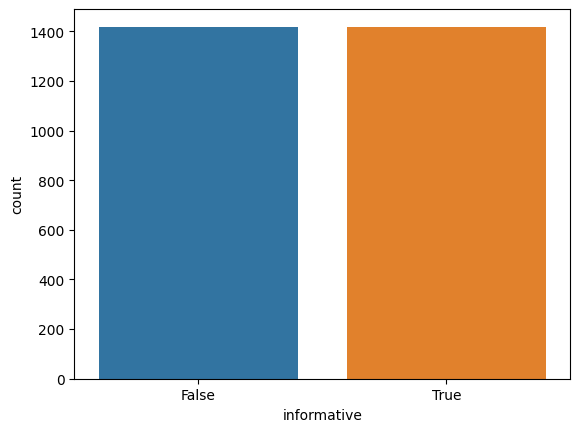

In [ ]:
sns.countplot(x='informative', data=df)

In [ ]:
num_false = len(df[df["informative"] == False])
num_true = len(df[df["informative"] == True])
print("There are "  +str(num_true) + " informative reviews. ")
print("There are "  +str(num_false) + " non-informative reviews. ")

There are 1419 informative reviews. 
There are 1419 non-informative reviews. 


In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_balanced.csv", index = False)

## Method using TF-IDF vectorization

### read data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_balanced.csv")

In [ ]:
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,Wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,Good app I love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song.. tnx spotify..,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,R\u0026amp;D,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,Has just about everything I need for my ears,False


### cleaning

In [ ]:
def clean_text(text):
  try:
    text = text.lower()
    punc =  string.punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text =  " ".join(text.split())
    text = convert_emojis_to_word(text)
    text = convert_emoticons(text)
    text = num_to_words(text)
    return text
  except:
    return ""


In [ ]:
df['User Review'] = df['User Review'].apply(clean_text)
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False


In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_cleaned.csv", index = False)

### Tokenizing/ lemmatizing/ stopword removal

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_cleaned.csv")
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False


In [ ]:
d1 = df[df["User Review"]=="nan" ]
len(d1)
# sns.countplot(x='informative', data=d1)

0

In [ ]:
def tokenize(text):
  try:
    words = word_tokenize(text)
    return words
  except: return ""

In [ ]:
def remove_stop_words(text):
  text = [word for word in text if word not in stopwords.words('english')]
  return text


In [ ]:
df["User_Review_processed"] = ""

for i in range(len(df.index)):
  text = df["User Review"][i]
  words = tokenize(text)
  df["User_Review_processed"][i] = words
df.head()

<ipython-input-27-01d5b9c41bf0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["User_Review_processed"][i] = words


,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"[wow, all, that, music]"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"[good, app, i, love, itt]"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"[now, i, can, listen, my, favorite, song, tnx,..."
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"[ru, twenty-six, ampd]"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"[has, just, about, everything, i, need, for, m..."


In [ ]:
df = df[df["User_Review_processed"]!=""]


In [ ]:
df["User_Review_processed"] = df["User_Review_processed"].apply(remove_stop_words)
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"[wow, music]"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"[good, app, love, itt]"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"[listen, favorite, song, tnx, spotify]"
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"[ru, twenty-six, ampd]"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"[everything, need, ears]"


In [ ]:
def lemmitize(words):
  lemmatizer = WordNetLemmatizer()
  lem = [lemmatizer.lemmatize(word) for word in words]
  return lem

In [ ]:
df["User_Review_processed"] = df["User_Review_processed"].apply(lemmitize)
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"[wow, music]"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"[good, app, love, itt]"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"[listen, favorite, song, tnx, spotify]"
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"[ru, twenty-six, ampd]"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"[everything, need, ear]"


In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_processed.csv", index = False)


### Divide data

In [14]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_processed.csv")
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"['wow', 'music']"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"['good', 'app', 'love', 'itt']"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"['listen', 'favorite', 'song', 'tnx', 'spotify']"
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"['ru', 'twenty-six', 'ampd']"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"['everything', 'need', 'ear']"


In [15]:
len(df)

2831

In [16]:
# keeping 20% to validate the models in the last step
y = df['informative']
X = df["User_Review_processed"]

X_train_all, X_validate, y_train_all, y_validate_tfidf = train_test_split(X, y, test_size=0.2, random_state=0)
print("There are " + str(len(X)) + " datapoint: ")
print("used for trainig with 10 fold cross validation: " + str(len(X_train_all)))
print("used for validation: " + str(len(X_validate)))

There are 2831 datapoint: 
used for trainig with 10 fold cross validation: 2264
used for validation: 567


In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, use_idf=True) # same vectorizer as in P4-CRISTAL

In [18]:
xtrain_tfidf = vectorizer.fit_transform(X_train_all)
X_validate_tfidf = vectorizer.transform(X_validate)
X_validate_tfidf.shape

(567, 10000)

In [19]:
xtrain_tfidf.shape

(2264, 10000)

In [20]:
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, use_idf=True) # same vectorizer as in P4-CRISTAL

X_train, X_test, y_train, y_test = train_test_split(xtrain_tfidf, y_train_all, test_size=0.2, random_state=0)
X_train.shape
# X_test.shape

(1811, 10000)

In [21]:
X_test.shape

(453, 10000)

### TF-IDF + SVM

In [48]:
svc = SVC()
parameters = { # used to search for the hyperparameters
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

cv = GridSearchCV(svc, parameters, cv=10) # cv = 5 --> 5 fold validation
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'C': 1, 'kernel': 'linear'}

0.675 (+/-0.055) for {'C': 0.1, 'kernel': 'linear'}
0.57 (+/-0.039) for {'C': 0.1, 'kernel': 'rbf'}
0.796 (+/-0.055) for {'C': 1, 'kernel': 'linear'}
0.78 (+/-0.057) for {'C': 1, 'kernel': 'rbf'}
0.777 (+/-0.068) for {'C': 10, 'kernel': 'linear'}
0.782 (+/-0.056) for {'C': 10, 'kernel': 'rbf'}


In [49]:
cv.best_estimator_

SVC(C=1, kernel='linear')

In [50]:
svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [51]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = svm_classifier.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 94.4%
Precision: 96.7%
Recall   : 92.1%
F1-score : 94.3%


In [52]:
joblib.dump(svm_classifier, '/content/drive/MyDrive/EECS6448/TF_IDF_SVM_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_SVM_model2.pkl']

In [53]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = svm_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 80.8%
Precision: 81.0%
Recall   : 78.4%
F1-score : 79.7%


For this model we used TF-IDF for the vectorization and SVM model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets and we can see that model is not underfitting (high training score) nor overfitting (the validation score are not too far from trainig score)

### TF-IDF + LR

In [67]:

lr = LogisticRegression(max_iter=3000)
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [3000, 3500, 4000, 4500, 5000]
}

cv = GridSearchCV(lr, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'C': 10, 'max_iter': 3000}

0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 3000}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 3500}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 4000}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 4500}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 5000}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 3000}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 3500}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 4000}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 4500}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 5000}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 3000}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 3500}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 4000}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 4500}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 5000}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 3000}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 3500}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 4000}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 4500}
0.781 

In [68]:
cv.best_estimator_

LogisticRegression(C=10, max_iter=3000)

In [69]:
logistic_classifier = LogisticRegression(C=10, max_iter=3000)
logistic_classifier.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=3000)

In [70]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = logistic_classifier.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 96.4%
Precision: 99.4%
Recall   : 93.5%
F1-score : 96.4%


In [71]:
joblib.dump(logistic_classifier, '/content/drive/MyDrive/EECS6448/TF_IDF_LR_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_LR_model2.pkl']

In [72]:
y_pred1 = logistic_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 79.7%
Precision: 79.2%
Recall   : 78.4%
F1-score : 78.8%


For this model we used TF-IDF for the vectorization and Logistic regression model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets and we can see that model is not underfitting (high training score) nor overfitting (the validation score are not too far from trainig score)

### TF-IDF + RF

In [60]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 300, 350, 400],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 400}

0.534 (+/-0.054) for {'max_depth': 2, 'n_estimators': 5}
0.654 (+/-0.086) for {'max_depth': 2, 'n_estimators': 50}
0.722 (+/-0.082) for {'max_depth': 2, 'n_estimators': 250}
0.719 (+/-0.067) for {'max_depth': 2, 'n_estimators': 300}
0.716 (+/-0.088) for {'max_depth': 2, 'n_estimators': 350}
0.723 (+/-0.097) for {'max_depth': 2, 'n_estimators': 400}
0.612 (+/-0.079) for {'max_depth': 4, 'n_estimators': 5}
0.757 (+/-0.077) for {'max_depth': 4, 'n_estimators': 50}
0.775 (+/-0.062) for {'max_depth': 4, 'n_estimators': 250}
0.783 (+/-0.062) for {'max_depth': 4, 'n_estimators': 300}
0.786 (+/-0.041) for {'max_depth': 4, 'n_estimators': 350}
0.779 (+/-0.055) for {'max_depth': 4, 'n_estimators': 400}
0.659 (+/-0.061) for {'max_depth': 8, 'n_estimators': 5}
0.76 (+/-0.05) for {'max_depth': 8, 'n_estimators': 50}
0.768 (+/-0.059) for {'max_depth': 8, 'n_estimators': 250}
0.778 (+/-0.063) for {'max_depth': 8, 'n_estimators': 300}
0.772 (+/-0.

In [61]:
cv.best_estimator_

RandomForestClassifier(n_estimators=400)

In [62]:
rf_classifier = RandomForestClassifier(n_estimators=250)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250)

In [63]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = rf_classifier.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 97.0%
Precision: 99.8%
Recall   : 94.3%
F1-score : 96.9%


In [64]:
joblib.dump(rf_classifier, '/content/drive/MyDrive/EECS6448/TF_IDF_RF_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_RF_model2.pkl']

In [65]:
y_pred1 = rf_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 79.0%
Precision: 80.9%
Recall   : 73.9%
F1-score : 77.2%


For this model we used TF-IDF for the vectorization and Random Forest model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets and we can see that model is not underfitting (high training score) nor overfitting (the validation score are not too far from trainig score)

### TF-IDF + EMNB (from P4 replication)

In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

multinomial_clf = MultinomialNB(alpha=0.1)
oneVsRest_rf = OneVsRestClassifier(multinomial_clf)

oneVsRest_rf.fit(X_train, y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=0.1))

In [74]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = oneVsRest_rf.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 94.3%
Precision: 94.6%
Recall   : 94.3%
F1-score : 94.4%


In [75]:
joblib.dump(oneVsRest_rf, '/content/drive/MyDrive/EECS6448/TF_IDF_EMNB_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_EMNB_model2.pkl']

In [76]:
y_pred1 = oneVsRest_rf.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 77.3%
Precision: 77.5%
Recall   : 74.3%
F1-score : 75.9%


For this classification we used EMNB classifications used in P4-CRISTAL replication package. however the we obtained different scores. The only difference between the the two method is that here, we performed more comprehensive cleaning and used RandomUnderSampler to balance the datasets instead of `resample` function used in P4-replication package which uses the sample functionlisty of pandas.

For this model we used TF-IDF for the vectorization and EMNB model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets and we can see that model is not underfitting (high training score) nor overfitting (the validation score are not too far from trainig score)

### TF-IDF + NB

In [77]:
nb = MultinomialNB()
parameters = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2, 2.5, 3]
}

cv = GridSearchCV(nb, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'alpha': 2.5}

0.775 (+/-0.085) for {'alpha': 0.1}
0.788 (+/-0.066) for {'alpha': 0.5}
0.789 (+/-0.064) for {'alpha': 1.0}
0.79 (+/-0.058) for {'alpha': 1.5}
0.793 (+/-0.052) for {'alpha': 2}
0.793 (+/-0.051) for {'alpha': 2.5}
0.784 (+/-0.062) for {'alpha': 3}


In [78]:
cv.best_estimator_

MultinomialNB(alpha=2.5)

In [79]:
nb = MultinomialNB(alpha=2.5)
nb.fit(X_train, y_train)

MultinomialNB(alpha=2.5)

In [80]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = nb.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 89.5%
Precision: 87.0%
Recall   : 93.4%
F1-score : 90.1%


In [81]:
joblib.dump(nb, '/content/drive/MyDrive/EECS6448/TF_IDF_NB_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_NB_model2.pkl']

In [82]:
y_pred1 = nb.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 79.2%
Precision: 74.8%
Recall   : 85.8%
F1-score : 79.9%


For this model we used TF-IDF for the vectorization and Naive bayes model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets and we can see that model is not underfitting (high training score) nor overfitting (the validation score are not too far from trainig score)

## Method using Bert vectorization

https://huggingface.co/sentence-transformers/all-mpnet-base-v2

### data preparation

#### Getting data

In [83]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_balanced.csv")
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,Wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,Good app I love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song.. tnx spotify..,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,R\u0026amp;D,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,Has just about everything I need for my ears,False


In [84]:
# drop cols
columns_to_drop = ['platform', 'pkg', 'id', 'lang', 'type', 'date', 'user', 'title', 'app']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)
df.head()

,User Review,informative
0,Wow all that music,False
1,Good app I love itt,False
2,now i can listen my favorite song.. tnx spotify..,False
3,R\u0026amp;D,False
4,Has just about everything I need for my ears,False


#### clean data for bert

In [85]:
def clean_text_1(text):

    # text = text.lower()
    punc =  string.punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text =  " ".join(text.split())
    text = convert_emojis_to_word(text)
    text = convert_emoticons(text)
    text = num_to_words(text)
    return text



In [86]:
df["User_Review_clean"] = df["User Review"].apply(clean_text_1)
df.head()

,User Review,informative,User_Review_clean
0,Wow all that music,False,Wow all that music
1,Good app I love itt,False,Good app I love itt
2,now i can listen my favorite song.. tnx spotify..,False,now i can listen my favorite song tnx spotify
3,R\u0026amp;D,False,Ru twenty-six ampD
4,Has just about everything I need for my ears,False,Has just about everything I need for my ears


In [87]:
len(df[df["informative"]==True])

1419

In [88]:
df = df[df["User_Review_clean"]!=""]

In [89]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_bert_processed.csv", index = False)

#### Splitting data

In [90]:
df.head()

,User Review,informative,User_Review_clean
0,Wow all that music,False,Wow all that music
1,Good app I love itt,False,Good app I love itt
2,now i can listen my favorite song.. tnx spotify..,False,now i can listen my favorite song tnx spotify
3,R\u0026amp;D,False,Ru twenty-six ampD
4,Has just about everything I need for my ears,False,Has just about everything I need for my ears


In [91]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Example text and labels (replace with your own data)
texts = df["User_Review_clean"]
labels = df['informative'] # Replace with your corresponding labels

# Tokenize and obtain BERT embeddings
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**tokens)
            embedding = outputs.last_hidden_state.mean(dim=1).numpy()  # Average pooling
            embeddings.append(embedding)
    return np.vstack(embeddings)

# Obtain BERT embeddings
bert_embeddings = get_bert_embeddings(texts)

# Flatten or aggregate embeddings based on your preference
# For example, you can flatten them:
flattened_embeddings = bert_embeddings.reshape((len(texts), -1))

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(flattened_embeddings, y_train_all, test_size=0.2, random_state=0)
X_train_all, X_validate_bert, y_train_all, y_validate_bert = train_test_split(flattened_embeddings, labels, test_size=0.2, random_state=0)

print("There are " + str(len(texts)) + " datapoint: ")
print("used for trainig with 10 fold cross validation: " + str(len(X_train_all)))
print("used for validation: " + str(len(X_validate_bert)))


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

There are 2831 datapoint: 
used for trainig with 10 fold cross validation: 2264
used for validation: 567


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=0)

In [93]:
print("Training data length: " + str(len(X_train)))
print("Test data length: " + str(len(X_test)))

Training data length: 1811
Test data length: 453


### Bert + SVM

In [94]:
svc = SVC()
parameters = { # used to search for the hyperparameters
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

cv = GridSearchCV(svc, parameters, cv=10) # cv = 5 --> 5 fold validation
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'C': 0.1, 'kernel': 'linear'}

0.813 (+/-0.045) for {'C': 0.1, 'kernel': 'linear'}
0.776 (+/-0.047) for {'C': 0.1, 'kernel': 'rbf'}
0.764 (+/-0.046) for {'C': 1, 'kernel': 'linear'}
0.812 (+/-0.048) for {'C': 1, 'kernel': 'rbf'}
0.716 (+/-0.061) for {'C': 10, 'kernel': 'linear'}
0.801 (+/-0.047) for {'C': 10, 'kernel': 'rbf'}


In [95]:
cv.best_estimator_

SVC(C=0.1, kernel='linear')

In [96]:
svm_classifier = SVC(C=0.1, kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [97]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = svm_classifier.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 88.5%
Precision: 89.3%
Recall   : 87.9%
F1-score : 88.6%


In [98]:
joblib.dump(svm_classifier, '/content/drive/MyDrive/EECS6448/bert_SVM_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_SVM_model2.pkl']

In [99]:
y_pred1 = svm_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 79.7%
Precision: 77.4%
Recall   : 81.7%
F1-score : 79.5%


For this model we used Bert for the vectorization and SVM model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets.

This model slightly underfits compare to the previous models but not overfitting (the validation score are not too far from trainig score)

### Bert + RF

In [100]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'max_depth': 32, 'n_estimators': 250}

0.726 (+/-0.051) for {'max_depth': 2, 'n_estimators': 5}
0.738 (+/-0.054) for {'max_depth': 2, 'n_estimators': 50}
0.739 (+/-0.052) for {'max_depth': 2, 'n_estimators': 250}
0.737 (+/-0.052) for {'max_depth': 4, 'n_estimators': 5}
0.773 (+/-0.048) for {'max_depth': 4, 'n_estimators': 50}
0.766 (+/-0.059) for {'max_depth': 4, 'n_estimators': 250}
0.741 (+/-0.05) for {'max_depth': 8, 'n_estimators': 5}
0.781 (+/-0.053) for {'max_depth': 8, 'n_estimators': 50}
0.779 (+/-0.047) for {'max_depth': 8, 'n_estimators': 250}
0.708 (+/-0.095) for {'max_depth': 16, 'n_estimators': 5}
0.778 (+/-0.027) for {'max_depth': 16, 'n_estimators': 50}
0.785 (+/-0.055) for {'max_depth': 16, 'n_estimators': 250}
0.712 (+/-0.058) for {'max_depth': 32, 'n_estimators': 5}
0.786 (+/-0.053) for {'max_depth': 32, 'n_estimators': 50}
0.794 (+/-0.051) for {'max_depth': 32, 'n_estimators': 250}
0.733 (+/-0.044) for {'max_depth': None, 'n_estimators': 5}
0.791 (+/-0.

In [101]:
cv.best_estimator_

RandomForestClassifier(max_depth=32, n_estimators=250)

In [102]:
rf_classifier = RandomForestClassifier(max_depth=16, n_estimators=250)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=250)

In [103]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = rf_classifier.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 98.2%
Precision: 99.4%
Recall   : 97.0%
F1-score : 98.2%


In [104]:
joblib.dump(rf_classifier, '/content/drive/MyDrive/EECS6448/bert_RF_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_RF_model2.pkl']

In [105]:
y_pred1 = rf_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 79.5%
Precision: 79.9%
Recall   : 76.6%
F1-score : 78.2%


For this model we used Bert for the vectorization and random forest model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets and we can see that model is not underfitting (high training score) nor overfitting (the validation score are not too far from trainig score)

### Bert + LR

In [112]:
lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [3000, 3500, 4000, 4500, 5000]
}

cv = GridSearchCV(lr, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

BEST PARAMS: {'C': 0.01, 'max_iter': 3000}

0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 3000}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 3500}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 4000}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 4500}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 5000}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 3000}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 3500}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 4000}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 4500}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 5000}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 3000}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 3500}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 4000}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 4500}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 5000}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 3000}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 3500}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 4000}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 4500}
0.7

In [113]:
cv.best_estimator_

LogisticRegression(C=0.01, max_iter=3000)

In [114]:
logistic_classifier = LogisticRegression(C=0.01, max_iter=3000)
logistic_classifier.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=3000)

In [115]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = logistic_classifier.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 82.7%
Precision: 82.6%
Recall   : 83.6%
F1-score : 83.1%


In [116]:
joblib.dump(logistic_classifier, '/content/drive/MyDrive/EECS6448/bert_LR_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_LR_model2.pkl']

In [117]:
y_pred1 = logistic_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 80.6%
Precision: 79.8%
Recall   : 79.8%
F1-score : 79.8%


For this model we used Bert for the vectorization and logistic regression model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets.

 we can see that model is underfitting slightly compare to other models but no overfitting (the validation score are not too far from trainig score)

### Bert + NB

In [120]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [121]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = nb_classifier.predict(X_train)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_train, y_pred1, average='binary')
accuracy = round(accuracy_score(y_train, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 72.0%
Precision: 71.5%
Recall   : 74.8%
F1-score : 73.1%


In [122]:
joblib.dump(nb_classifier, '/content/drive/MyDrive/EECS6448/bert_NB_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_NB_model2.pkl']

In [123]:
y_pred1 = nb_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
accuracy = round(accuracy_score(y_test, y_pred1), 3)
print(f'Accuracy: {accuracy*100:.1f}%')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Accuracy: 72.0%
Precision: 69.5%
Recall   : 74.3%
F1-score : 71.8%


For this model we used Bert for the vectorization and Naive bayes model for the classification. We split the data into 80% training and 20% validation. to ensure that the model is not overfitting or underfitting we calcuate the accuracy/ precision/ recall and F measure for both training and validation sets.

 we can see that model is underfitting slightly compare to other models but no overfitting (the validation score are not too far from trainig score)

## Analysis

In [127]:
models = {}

for mdl in ['TF_IDF_EMNB', 'TF_IDF_LR', 'TF_IDF_NB', 'TF_IDF_RF', 'TF_IDF_SVM', 'bert_LR', 'bert_NB', 'bert_RF', 'bert_SVM']:
    models[mdl] = joblib.load('/content/drive/MyDrive/EECS6448/{}_model2.pkl'.format(mdl))

models

{'TF_IDF_EMNB': OneVsRestClassifier(estimator=MultinomialNB(alpha=0.1)),
 'TF_IDF_LR': LogisticRegression(C=10, max_iter=3000),
 'TF_IDF_NB': MultinomialNB(alpha=2.5),
 'TF_IDF_RF': RandomForestClassifier(n_estimators=250),
 'TF_IDF_SVM': SVC(C=1, kernel='linear'),
 'bert_LR': LogisticRegression(C=0.01, max_iter=3000),
 'bert_NB': GaussianNB(),
 'bert_RF': RandomForestClassifier(max_depth=16, n_estimators=250),
 'bert_SVM': SVC(C=0.1, kernel='linear')}

In [128]:
def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    accuracy = round(accuracy_score(labels, pred), 3)
    precision, recall, f1score, support = precision_recall_fscore_support(labels, pred, average='binary')
    precision = round(precision, 3)
    recall = round(recall, 3)
    f1score = round(f1score, 3)
    print('{} --> Accuracy= {} | Precision= {} | Recall= {} | F1 score= {}'.format(name, accuracy, precision, recall, f1score ))


In [129]:
for name, mdl in models.items():
  tfidf_mdls = ['TF_IDF_EMNB', 'TF_IDF_LR', 'TF_IDF_NB', 'TF_IDF_RF', 'TF_IDF_SVM']
  bert_mdls = ['bert_LR', 'bert_NB', 'bert_RF', 'bert_SVM']
  if name in tfidf_mdls:
    evaluate_model(name, mdl, X_validate_tfidf, y_validate_tfidf)
  if name in bert_mdls:
    evaluate_model(name, mdl, X_validate_bert, y_validate_bert)

TF_IDF_EMNB --> Accuracy= 0.757 | Precision= 0.709 | Recall= 0.843 | F1 score= 0.77
TF_IDF_LR --> Accuracy= 0.787 | Precision= 0.768 | Recall= 0.799 | F1 score= 0.784
TF_IDF_NB --> Accuracy= 0.762 | Precision= 0.699 | Recall= 0.891 | F1 score= 0.783
TF_IDF_RF --> Accuracy= 0.781 | Precision= 0.8 | Recall= 0.73 | F1 score= 0.763
TF_IDF_SVM --> Accuracy= 0.788 | Precision= 0.775 | Recall= 0.792 | F1 score= 0.783
bert_LR --> Accuracy= 0.811 | Precision= 0.795 | Recall= 0.821 | F1 score= 0.808
bert_NB --> Accuracy= 0.709 | Precision= 0.686 | Recall= 0.734 | F1 score= 0.709
bert_RF --> Accuracy= 0.802 | Precision= 0.791 | Recall= 0.803 | F1 score= 0.797
bert_SVM --> Accuracy= 0.808 | Precision= 0.798 | Recall= 0.807 | F1 score= 0.802


In [130]:
data = pd.DataFrame()
data["Model"] = ['TF_IDF_EMNB', 'TF_IDF_LR', 'TF_IDF_NB', 'TF_IDF_RF', 'TF_IDF_SVM', 'bert_LR', 'bert_NB', 'bert_RF', 'bert_SVM' ]
data["Accuracy"] = [0.757, 0.787,  0.762,0.781, 0.788 , 0.811, 0.709, 0.802, 0.808]
data["Precision"] = [0.709,0.768, 0.699, 0.8, 0.775, 0.795, 0.686, 0.791, 0.798 ]
data["Recall"] = [0.843, 0.799,0.891 , 0.73, 0.792, 0.821, 0.734, 0.803, 0.807]
data["F1 score"] = [0.77, 0.784, 0.783, 0.763, 0.783, 0.808, 0.709, 0.797, 0.802]
data.head(10)

,Model,Accuracy,Precision,Recall,F1 score
0,TF_IDF_EMNB,0.757,0.709,0.843,0.770
1,TF_IDF_LR,0.787,0.768,0.799,0.784
2,TF_IDF_NB,0.762,0.699,0.891,0.783
3,TF_IDF_RF,0.781,0.800,0.730,0.763
4,TF_IDF_SVM,0.788,0.775,0.792,0.783
5,bert_LR,0.811,0.795,0.821,0.808
6,bert_NB,0.709,0.686,0.734,0.709
7,bert_RF,0.802,0.791,0.803,0.797
8,bert_SVM,0.808,0.798,0.807,0.802


Text(0.5, 1.0, 'Cross-model metric comparison')

<Figure size 800x500 with 0 Axes>

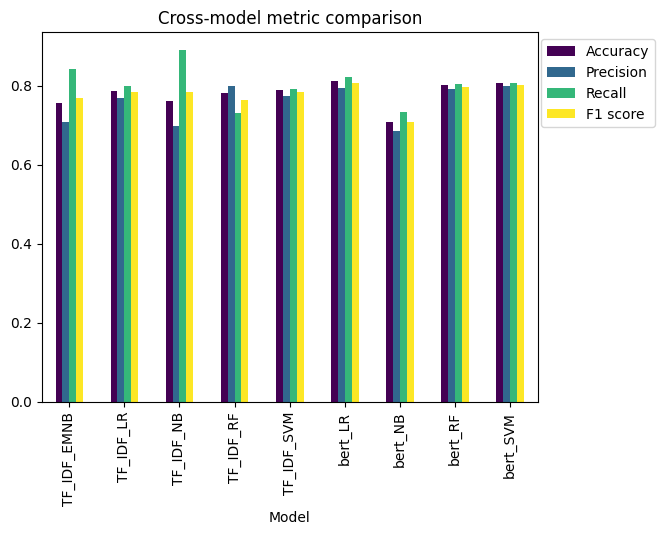

In [131]:
plt.figure(figsize=(8,5))
data.plot(x="Model", y=["Accuracy", "Precision", "Recall", "F1 score"], kind="bar", colormap='viridis')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.title("Cross-model metric comparison")

For the purpose of this project, we took a benchmarking approach to improve the AR Miner suggested by [1]. We used the labeled dataset `Informative_Training_Set.xlsx` to perform our analysis.

previously the same data was used to create AR miner to classify reviews as informative or non-informative. The approach preprocessed the reviews by removing stopwords, converting the them to lower case, stemming and tokenizing. Additionally the data is resampled by simple redsampling of the dataframe using sample function of pandas to balance the dataset.  Finally the TF-IDF approach was used to vectorize the reviews. The processed data then is used to train EMNB algorithm which results in 81.5%. This approch is slightly limited as the resampling done is not best method to ensure randomness of the selected data.

In this section we first cleaned the data by:


1.   converting reviews to lower case
2.   remove punctuation and whitespaces
3.   converting emojis & emoticons to useful information
4.   converting numbers to words
5.   stop word removal, tokenization, lemmatization (for TF-IDF driven methods only)

Then we resampled the data using RandomUnderSampler algorithm of sklearn library to ensure a balanced data. Then we used Two methods of vectorization: TF-IDF and Bert model (bert-base-uncased).

for the each vectorization method, we training the following algorithms:
1. TF-IDF + EMNB: Approach used in both paper & previous replication
2. TF-IDF + Logistic regression
3. TF-IDF + SVM
4. TF-IDF + Random Forest
5. TF-IDF + Naive Bayes
6. bert + LR
7. bert + NB (Gaussion)
8. bert + Random Forest
9. Bert + SVM

Using our approach previously used TF-IDF + EMNB results in 77% F-score. The score can improve to 80.8% by replacing this model with bert + LR in AR Miner. However bert+LR model has slightly lower recall in comparison. Since for CRISTAL model, finding positive instance (informative reviews in this case) is more important than negative instances, we might prioritize recall score which would make TF_IDF_NB model the best among the tested models with 89.1% recall score and F1 score of 78.3% (very slightly higher than the EMNB)








**Reference:**

[1] Palomba, F., Linares-Vásquez, M., Bavota, G., Oliveto, R., Di Penta, M., Poshyvanyk, D., & De Lucia, A. (2018). Crowdsourcing user reviews to support the evolution of mobile apps. Journal of Systems and Software, 137, 143-162.

# B. Benchmarking Algorithms for Link Identifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

In [ ]:
!python -VVV
!pip install hypy_utils
from __future__ import annotations

import json
import os
import shlex
import tempfile
import warnings
import xml.etree.ElementTree as ET
from datetime import datetime
from pathlib import Path
from subprocess import check_output, check_call
from typing import NamedTuple

import dateutil.parser
import nltk
import pandas as pd
from hypy_utils import json_stringify
from nltk.corpus import stopwords


warnings.filterwarnings('ignore')

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
def download_data(re_download: bool = False):
    if not re_download and os.path.isdir('github'):
        print('Data exists, skipping download...')
        return

    if not os.path.isfile('/content/drive/MyDrive/EECS6448/data.tar.zst'):
        !wget -O data.tar.zst "https://hydevelop-my.sharepoint.com/:u:/g/personal/me_hydev_org/EbofDOyJNrhGlWAeb4xbS6MBKToILLw5rk8jMFKKjYDULg?download=1" -q --show-progress

    !echo 'Installing ZSTD'
    !apt update > apt.log 2>/dev/null && apt install gzip zstd pv -y >> apt.log 2>/dev/null \
            && echo 'ZSTD Installed Successfully' || echo 'ZSTD Install Failed (check apt.log)'

    !echo 'Extracting...'
    # !pv data.tar.zst -f | tar -I zstd -x
    !tar -I zstd -x -f /content/drive/MyDrive/EECS6448/data.tar.zst --checkpoint=.4096 --totals


download_data()

Installing ZSTD
ZSTD Installed Successfully
Extracting...
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Total bytes read: 20814981120 (20GiB, 99MiB/s)


In [ ]:
apps: dict[str, str] = json.loads(Path('other_data/app_sets/selected_apps.json').read_text())
print('Number of selected apps/repos:', len(apps))

Number of selected apps/repos: 637


In [ ]:
DIR_GITHUB = Path('github')
DIR_REVIEWS = Path('reviews')

DIR_REPO_ISSUES =         lambda repo: DIR_GITHUB / 'repos' / repo / 'issues.json'
DIR_REPO_ISSUE_COMMENTS = lambda repo, issue: DIR_GITHUB / 'repos' / repo / 'issues' / str(issue) / 'comments.json'
DIR_REPO_COMMITS =        lambda repo: DIR_GITHUB / 'commits' / repo / 'commits.json'
DIR_REPO_STRINGS_XML =    lambda repo: DIR_GITHUB / 'source' / 'strings.xml' / f"{repo.replace('/', '-')}.xml"
DIR_REPO_LOC =            lambda repo: DIR_GITHUB / 'source' / 'loc' / f"{repo.replace('/', '-')}.txt"

DIR_APP_REVIEWS =         lambda pkg: DIR_REVIEWS / 'play_store' / f'{pkg}.json'
DIR_APP_REVIEWS_PRED =    lambda pkg: DIR_REVIEWS / 'play_store_pred' / f'{pkg}.json'
DIR_APP_RELEASES =        lambda pkg: DIR_REVIEWS / 'f_droid_releases' / f'{pkg}.json'

In [ ]:
import shutil


class ExtractedIssue(NamedTuple):
    id: int
    title: str
    desc: str
    author: str

    # Dates
    opened: str
    modified: str
    closed: str | None

    comments: list[ExtractedComment]


class ExtractedComment(NamedTuple):
    issue: int
    author: str
    date: str
    text: str


def issue_extract(repo: str) -> list[ExtractedIssue]:
    """
    From raw GitHub data, collect title, description, author, open/close time, and comments of issues

    :param repo: GitHub repo in the format of "owner/repo"
    """
    issues = json.loads(DIR_REPO_ISSUES(repo).read_text('utf-8'))
    comments = {i['number']: DIR_REPO_ISSUE_COMMENTS(repo, i['number']) for i in issues}
    comments = {id: json.loads(path.read_text('utf-8')) if path.is_file() else [] for id, path in comments.items()}
    comments = {id: [ExtractedComment(id, c['user']['login'], c['created_at'], c['body']) for c in cs] for id, cs in comments.items()}
    issues = [ExtractedIssue(int(i['number']), i['title'], i['body'], i['user']['login'], i['created_at'], i['updated_at'], i['closed_at'], comments[i['number']])
              for i in issues]
    return issues


# Test issue extractor
pd.DataFrame(issue_extract('zxing/zxing'))[:5]

,id,title,desc,author,opened,modified,closed,comments
0,1558,Add zxing-dart link,None,shirne,2022-08-25T01:27:07Z,2022-08-25T01:34:36Z,2022-08-25T01:34:36Z,[]
1,1557,update nu-book/zxing-cpp link,nu-book/zxing-cpp is now reachable under zxing...,axxel,2022-08-24T22:38:53Z,2022-08-24T22:45:12Z,2022-08-24T22:45:12Z,[]
2,1556,"QR Code Scans on zxing.org, but not in Browser...",The following QR code scans in the zxing.org w...,wisefool769,2022-08-24T21:08:49Z,2022-08-24T23:17:18Z,2022-08-24T21:19:12Z,"[(1556, srowen, 2022-08-24T21:19:12Z, You can ..."
3,1555,auto zoom?,"Hello, does zxing have long-distance automatic...",langyangyangzzZ,2022-08-22T01:31:18Z,2022-08-22T22:45:52Z,2022-08-22T01:40:31Z,"[(1555, srowen, 2022-08-22T01:40:31Z, It just ..."
4,1554,Can you support the OpenHarmony JavaScript ver...,I am developing an OpenHarmony application wit...,DoraCoder,2022-08-17T08:52:38Z,2022-08-17T12:05:37Z,2022-08-17T12:05:37Z,"[(1554, srowen, 2022-08-17T12:05:37Z, No there..."


In [ ]:
class ExtractedCommit(NamedTuple):
    sha: str
    author: str
    email: str
    time: str
    message: str
    file_names: list[str]

    def get_time(self) -> datetime:
        return dateutil.parser.isoparse(self.time)


def git_log(path: Path) -> list[ExtractedCommit]:
    """
    Call and parse git log. This function requires that git>=2.37.1 is installed on your system.

    :param path: Path of git repository
    :return: List of commits
    """
    # check_call(shlex.split('git config diff.renames 0'))
    cmd = f"git -c 'diff.renamelimit=0' -c 'diff.renames=0' -C '{path.absolute()}' log --name-status --diff-filter=AMD --pretty=format:'START_COMMIT_QwQ %H%n%aN%n%aE%n%aI%n%s%n'"
    log = check_output(shlex.split(cmd)).decode('utf-8', 'ignore')

    def extract_commit(block: str) -> ExtractedCommit:
        try:
            lines = block.split('\n')
            sha, author, email, date, message = lines + [""] if len(lines) == 4 else lines[:5]
            files = [f.replace('\t', '/') for f in lines[6:]]
            return ExtractedCommit(sha, author, email, date, message, files)
        except Exception as e:
            print(f'========== Commit Extract Error {e} ==========\n{block}\n==========')

    return [extract_commit(c.strip()) for c in log.split('START_COMMIT_QwQ') if c]


def find(name: str, path: Path) -> Path:
    for root, dirs, files in os.walk(path):
        if name in files:
            return Path(root, name)


def commit_collect(repo: str, verbose: bool = False) -> list[ExtractedCommit]:
    """
    Extract commits from GitHub repo, collect sha, time, file names, author, message

    Also extracts strings.xml for GUI terms exclusion.
    Also counts the number of lines of java code.

    :param repo:
    :param verbose:
    :return:
    """
    out_path = DIR_REPO_COMMITS(repo)
    strings_out = DIR_REPO_STRINGS_XML(repo)
    strings_out.parent.mkdir(parents=True, exist_ok=True)
    loc_out = DIR_REPO_LOC(repo)
    loc_out.parent.mkdir(parents=True, exist_ok=True)

    if out_path.is_file():
        return [ExtractedCommit(*d) for d in json.loads(out_path.read_text('utf-8'))]

    with tempfile.TemporaryDirectory() as tmp:
        tmp = Path(tmp)

        # tmp = Path(f'/tmp/github/{repo}')
        # tmp.mkdir(parents=True, exist_ok=True)

        # Clone repository
        if verbose:
            print(f'Cloning {repo} into {tmp}')
        if not (tmp / '.git').is_dir():
            check_call(shlex.split(f'git clone --quiet "https://github.com/{repo}" "{tmp}"'))

        # Extract strings.xml
        strings = find('strings.xml', tmp)
        if strings is not None:
            shutil.copyfile(strings, strings_out)

        # Count lines of java code
        java_files = [Path(root, f) for root, dirs, files in os.walk(tmp) for f in files if f.endswith('java')]
        loc = sum(f.read_bytes().decode('utf-8', 'ignore').count('\n') for f in java_files)
        loc_out.write_text(str(loc))

        # Get git log to json
        commits = git_log(tmp)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        out_path.write_text(json_stringify(commits), 'utf-8')
        return commits


# Test commit extract
pd.DataFrame(commit_collect('zxing/zxing'))[:5]

,sha,author,email,time,message,file_names
0,45df47022794eedcffd7e4409200100be5b8e631,Sean Owen,srowen@gmail.com,2022-07-20T13:29:55-05:00,"Add basic support for thread interruption, and...",[M/core/src/main/java/com/google/zxing/MultiFo...
1,2369986a0d97d626c2e453b7e3e8a2d2a6a04cff,Daniel Gredler,daniel.gredler@gmail.com,2022-07-19T19:36:01-04:00,Add description for OkapiBarcode project (#1545),[M/README.md]
2,8ecde0088f521579616b7ec6ebad5aeb3eaa03b2,Daniel Gredler,daniel.gredler@gmail.com,2022-07-19T19:12:52-04:00,Fix Maxicode decoding of CR (carriage return);...,[M/core/src/main/java/com/google/zxing/maxicod...
3,5231442ebc14ae7f1eb6d916983705b682d1bf96,Sean Owen,srowen@gmail.com,2022-07-06T13:16:34-05:00,Misc dependency updates,"[M/core/pom.xml, M/core/src/main/java/com/goog..."
4,78c2a9c4401e166be22ba1483cc1c7d090bdf8b8,Sean Owen,srowen@gmail.com,2022-07-05T18:34:45-05:00,"In multi QR code finder, only consider multipl...",[M/core/src/main/java/com/google/zxing/multi/q...


In [ ]:
from hypy_utils.tqdm_utils import pmap

_ = pmap(commit_collect, apps.values(), desc='Caching commits...')

Caching commits...: 100%|██████████| 637/637 [00:10<00:00, 60.77it/s]


In [ ]:
import string
from hypy_utils.nlp_utils import camel_split
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')


STOPWORDS = {w.lower() for w in set(Path('other_data/p4-stopwords.txt').read_text('utf-8').splitlines())\
    .union(stopwords.words('english'))}
STEMMER = PorterStemmer()


def gui_keywords(repo: str) -> set[str]:
    """
    Get the set of GUI-keywords from strings.xml
    """
    strings_xml = DIR_REPO_STRINGS_XML(repo)

    if not strings_xml.is_file():
        return set()

    return {w.lower() for el in ET.parse(strings_xml).getroot().iter('string') for w in el.attrib['name'].split('_')}


def process_text(text: str, stop: set[str]) -> str:
    """
    Camel case splitting, underscore splitting, stopword removal, stem

    :param text: Original text
    :param stop: Stopword set to use
    :return: Processed text
    """
    # Remove links
    text = ' '.join(t for t in text.split(' ') if not (t.startswith('http://') or t.startswith('https://')))

    # Remove punctuations (replace punctuations with spaces)
    text = ''.join(c if c not in string.punctuation else ' ' for c in text)
    while '  ' in text:
        text = text.replace('  ', ' ')

    # Tokenize
    text = nltk.word_tokenize(text)

    # Camel split
    text = [s for w in text for s in camel_split(w)]

    # Remove stopwords and stem
    text = [STEMMER.stem(w) for w in text if w not in stop]

    # Join
    return ' '.join(text)


def preprocess_issues(repo: str) -> dict[int, str]:
    """
    Preprocess issues for repo

    :param repo:
    :return: dict[issue_id] = preprocessed issue text
    """
    issues: list[ExtractedIssue] = issue_extract(repo)

    # Combine title and body
    issues: dict[int, str] = {i.id: f'{i.title} {i.desc}' for i in issues}

    # Process text
    issues = {id: process_text(text, STOPWORDS - gui_keywords(repo)) for id, text in issues.items()}

    return issues


def preprocess_commits(repo: str) -> dict[str, str]:
    """
    Preprocess commits for repo

    :param repo:
    :return: dict[commit_hash] = preprocessed commit text
    """
    commits: list[ExtractedCommit] = commit_collect(repo)

    # Combine commit message with names modified (without extensions)
    commits: dict[str, str] = {c.sha: c.message + ' ' + '  '.join(Path(f).stem for f in c.file_names) for c in commits}

    # Process text
    commits = {sha: process_text(text, STOPWORDS - gui_keywords(repo)) for sha, text in commits.items()}

    return commits


pd.DataFrame(preprocess_commits('zxing/zxing').items(), columns=['sha', 'processed'])[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,sha,processed
0,45df47022794eedcffd7e4409200100be5b8e631,add basic interrupt add protect run request we...
1,2369986a0d97d626c2e453b7e3e8a2d2a6a04cff,add descript okapi barcod project 1545 readm
2,8ecde0088f521579616b7ec6ebad5aeb3eaa03b2,fix maxicod decod cr carriag fix 1543 1544 dec...
3,5231442ebc14ae7f1eb6d916983705b682d1bf96,misc depend updat pom bit matrix eci string bu...
4,78c2a9c4401e166be22ba1483cc1c7d090bdf8b8,in multi qr code finder consid multipli center...
5,75dbbb00dd10a5f3683553e1d56b8209b9db48e2,micro optim to help high level encod
6,78faea80583e6fc903bdb8c146e8ff499b60c307,prevent encod empti pdf417 1523 pd f417 high l...
7,c7a7b30f0497e01bed97fd465e4645594ee35fda,add orient pdf417 barcod to result metadata 15...
8,83cdc82aa15feb819f7ee4906d473874fbf4c93a,updat queri mobil web page add integr to sure ...
9,3aa3832840af45083a10ee6a9247c4f82988d120,readm md descript nu book 1521 readm


In [ ]:
class ExtractedReview(NamedTuple):
    id: str
    score: int
    text: str
    version: str
    date: str

    # Informativeness predicted by AR-Miner
    informative: bool
    # Language predicted by langid
    lang: str


def load_reviews(app: str) -> list[ExtractedReview]:
    """
    Load reviews of an app

    :param app: App package name
    :return: Reviews
    """
    return [ExtractedReview(*[r[k] for k in ['id', 'score', 'text', 'version', 'date', 'pred_informative', 'pred_language']])
            for r in json.loads(DIR_APP_REVIEWS_PRED(app).read_text())]


pd.DataFrame(load_reviews('a2dp.Vol')).sample(200).to_csv('informative_eval.csv', index=False)
pd.DataFrame(load_reviews('a2dp.Vol'))[:10]

,id,score,text,version,date,informative,lang
0,b1fc6681-4f28-4c03-851e-3384c6d2dcbd,5,I love this app this app solve my problem abou...,2.13.0.4,2022-08-15T13:40:10.442Z,True,en
1,b1075cba-5348-47b8-b94d-ea6c0b9bbf2a,5,Excellent,None,2022-06-21T20:11:42.723Z,False,de
2,c1f6bf41-5d2e-4900-83ae-3f16d2d32710,5,I Love this app! Love it!,2.13.0.4,2021-11-24T01:22:28.905Z,False,en
3,6c856fdf-10b4-41f1-b456-003c6bdb56dd,5,LsabethDixon Save,2.13.0.4,2021-10-21T16:47:37.307Z,True,en
4,1d014efe-b7d4-4052-a524-e971860d100e,1,Garbage,None,2021-08-09T07:29:27.390Z,True,en
5,9e119827-e4f9-4f39-8d95-caf8bb1c622d,5,Best,2.12.9.3,2021-04-15T10:57:46.540Z,False,en
6,f531887e-1ce5-4c67-b40d-e4f485fe1a04,5,Great for car / headphone pairing. Also reads ...,2.13.0.4,2021-02-16T12:20:19.290Z,False,en
7,17d6dc23-323a-40f8-bd12-97355b9bb474,5,App is good for my stupid MIUI12 not memorizin...,None,2020-12-20T21:23:43.183Z,False,en
8,a76bffa4-2e12-4a71-8a60-0ba10aa87924,1,Notthing worked,None,2020-12-01T07:43:25.731Z,True,en
9,0d959d21-9701-4adc-bc77-e5b97c055299,1,"Does nothing. Unfriendly UI.No info, no help, ...",2.13.0.4,2020-11-09T20:30:29.165Z,True,en


### Bert + cosine similarity

In [ ]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=afee3b497c8a8d9fbd96ba9c44f8cfa6e8b6ae1f51dc5b584ba980f1efd7dd6e
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


## Link Identifier  + BERT

In [ ]:
from typing import Callable
from hypy_utils.tqdm_utils import pmap
# from transformers import BertTokenizer, BertModel
import numpy
from sentence_transformers import SentenceTransformer, util
import torch
import torch.multiprocessing as mp
import tensorflow as tf
cos = torch.nn.CosineSimilarity(dim=0)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# mp.set_start_method('spawn')
model = SentenceTransformer('bert-base-nli-mean-tokens')
# model = model.to('cuda:0')
# model.eval()
pool = model.start_multi_process_pool()
from scipy import spatial




SIMILARITY_THRESHOLD = 0.7


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str, reviews: list[ExtractedReview] | None = None):
    """
    Link issues and commits to reviews

    :param reviews: List of reviews
    :param app: App package name
    :return:
    """
    repo = apps[app]
    # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    # model = model.to('cuda:0')

    out = Path(f'/p4-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    issues, commits = issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Load and filter reviews (informative and english reviews only)
    reviews_defined = reviews is not None
    if not reviews_defined:
        reviews = [r for r in load_reviews(app) if r.informative and r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}


        ## (Chris:) This part is fixed with Bert/RoBERTa/FastText
        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
            # encoding1 = model.encode(list(review_words), convert_to_tensor=True)
            # encoding2 = model.encode(list(target_words), convert_to_tensor=True)
            # embedding_list = []
            # encoding1 = model.encode_multi_process(list(review_words), pool)
            # encoding2 = model.encode_multi_process(list(target_words), pool)
            # # encoding1 = tf.convert_to_tensor(encoding1, dtype=None, dtype_hint=None, name=None)
            # # encoding2 = tf.convert_to_tensor(encoding2, dtype=None, dtype_hint=None, name=None)
            # # print(type(encoding1))
            # # print(len(encoding1))
            # # final_sim = util.cos_sim(encoding1, encoding2)
            # # final_sim = cosine_similarity(encoding1, encoding2)
            # # final_sim = util.pytorch_cos_sim(encoding1, encoding2)
            # embedding_list = [];
            # embedding_list.append(encoding1); embedding_list.append(encoding2) # the len(embedding_list) = 2
            # scores = cosine_similarity(embedding_list) # contains 4 elements with numpy.ndarray type
            # scores = scores[~np.eye(scores.shape[0],dtype=bool)].reshape(scores.shape[0],-1) # remove diagonal
            sen = [str(review_words), str(target_words)]
            # with torch.no_grad():
            sen_embeddings = model.encode_multi_process(sen, pool)
            # print(sen_embeddings.shape)
            cosine_score = cosine_similarity(
                      [sen_embeddings[0]],
                      sen_embeddings[1:]
                      )#scores[0][0] #  cosine score
            # print(cosine_score[0][0])

            if cosine_score[0][0] >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    if not reviews_defined:
        out.parent.mkdir(parents=True, exist_ok=True)
        out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

  0%|          | 2/637 [1:23:40<442:47:12, 2510.29s/it]

In [1]:
def link_stats():
    # links = pmap(link_issues_to_reviews, list(apps.keys()))
    links = [json.loads(Path(f'p4-processed/cir-links/{a}').read_text()) for a in os.listdir(f'p4-processed/cir-links')]
    all_links = {}
    for d in links:
        all_links.update(d)

    total = len(all_links)

    def percent(lst: list, msg: str):
        print(f'{len(lst)} ({len(lst) / total * 100:.1f}%) {msg}')

    print(f'There are a total of {total} reviews.')
    has_issues = [(r, d) for r, d in all_links.items() if d['issues']]
    percent(has_issues, 'reviews linked with at least one issue')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits']]
    percent(has_commits, 'reviews linked with at least one commit')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits'] and d['issues']]
    percent(has_commits, 'reviews linked with at least one issue and one commit')
    print(f'Average number of issues linked (ignoring zeros): {sum(len(d["issues"]) for r, d in has_issues) / len(has_issues):.1f}')
    print(f'Average number of commits linked (ignoring zeros): {sum(len(d["commits"]) for r, d in has_commits) / len(has_commits):.1f}')


link_stats()

NameError: ignored

## Link Identifier + RoBERTa

In [ ]:
from typing import Callable
from hypy_utils.tqdm_utils import pmap
# from transformers import BertTokenizer, BertModel
import numpy
from sentence_transformers import SentenceTransformer, util
import torch
import torch.multiprocessing as mp
import tensorflow as tf
cos = torch.nn.CosineSimilarity(dim=0)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# mp.set_start_method('spawn')
model = SentenceTransformer('sentence-transformers/stsb-roberta-base-v2')
# model = model.to('cuda:0')
# model.eval()
pool = model.start_multi_process_pool()
from scipy import spatial




SIMILARITY_THRESHOLD = 0.7


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str, reviews: list[ExtractedReview] | None = None):
    """
    Link issues and commits to reviews

    :param reviews: List of reviews
    :param app: App package name
    :return:
    """
    repo = apps[app]
    # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    # model = model.to('cuda:0')

    out = Path(f'/p4-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    issues, commits = issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Load and filter reviews (informative and english reviews only)
    reviews_defined = reviews is not None
    if not reviews_defined:
        reviews = [r for r in load_reviews(app) if r.informative and r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}


        ## (Chris:) This part is fixed with Bert/RoBERTa/FastText
        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            sen = [str(review_words), str(target_words)]
            # with torch.no_grad():
            sen_embeddings = model.encode_multi_process(sen, pool)
            # print(sen_embeddings.shape)
            cosine_score = cosine_similarity(
                      [sen_embeddings[0]],
                      sen_embeddings[1:]
                      )#scores[0][0] #  cosine score
            # print(cosine_score[0][0])

            if cosine_score[0][0] >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    if not reviews_defined:
        out.parent.mkdir(parents=True, exist_ok=True)
        out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

## Link Identifier  + FastText

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=7e5ac3ea0b6045e78798d1ad78aab7f8a9b9d1a688cdcad9f50951cccb13fff2
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
# Test cell for fasttext
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
# Load the FastText model
model = fasttext.load_model('cc.en.300.bin')

# Preprocess the text
text1 = 'This is a piece of text'
text2 = 'This is another piece of text'
tokens1 = fasttext.tokenize(text1)
tokens2 = fasttext.tokenize(text2)
tokens1 = [token.lower() for token in tokens1]
tokens2 = [token.lower() for token in tokens2]

# Generate word vectors for each piece of text
vector1 = model.get_sentence_vector(tokens1)
vector2 = model.get_sentence_vector(tokens2)

# Calculate the similarity between the vectors using cosine similarity
from scipy.spatial.distance import cosine
similarity = 1 - cosine(vector1, vector2)
print('Similarity:', similarity)

In [ ]:
from typing import Callable
from hypy_utils.tqdm_utils import pmap
# from transformers import BertTokenizer, BertModel
import numpy
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
# Load the FastText model
model = fasttext.load_model('cc.en.300.bin')
from scipy import spatial




SIMILARITY_THRESHOLD = 0.7


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str, reviews: list[ExtractedReview] | None = None):
    """
    Link issues and commits to reviews

    :param reviews: List of reviews
    :param app: App package name
    :return:
    """
    repo = apps[app]
    # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    # model = model.to('cuda:0')

    out = Path(f'/p4-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    issues, commits = issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Load and filter reviews (informative and english reviews only)
    reviews_defined = reviews is not None
    if not reviews_defined:
        reviews = [r for r in load_reviews(app) if r.informative and r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}


        ## (Chris:) This part is fixed with Bert/RoBERTa/FastText
        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            tokens1 = fasttext.tokenize(review_words)
            tokens2 = fasttext.tokenize(target_words)
            tokens1 = [token.lower() for token in tokens1]
            tokens2 = [token.lower() for token in tokens2]

            # Generate word vectors for each piece of text
            vector1 = model.get_sentence_vector(tokens1)
            vector2 = model.get_sentence_vector(tokens2)

            # Calculate the similarity between the vectors using cosine similarity
            from scipy.spatial.distance import cosine
            similarity = 1 - cosine(vector1, vector2)

            if similarity >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    if not reviews_defined:
        out.parent.mkdir(parents=True, exist_ok=True)
        out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

In [ ]:
def link_stats():
    # links = pmap(link_issues_to_reviews, list(apps.keys()))
    links = [json.loads(Path(f'p4-processed/cir-links/{a}').read_text()) for a in os.listdir(f'p4-processed/cir-links')]
    all_links = {}
    for d in links:
        all_links.update(d)

    total = len(all_links)

    def percent(lst: list, msg: str):
        print(f'{len(lst)} ({len(lst) / total * 100:.1f}%) {msg}')

    print(f'There are a total of {total} reviews.')
    has_issues = [(r, d) for r, d in all_links.items() if d['issues']]
    percent(has_issues, 'reviews linked with at least one issue')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits']]
    percent(has_commits, 'reviews linked with at least one commit')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits'] and d['issues']]
    percent(has_commits, 'reviews linked with at least one issue and one commit')
    print(f'Average number of issues linked (ignoring zeros): {sum(len(d["issues"]) for r, d in has_issues) / len(has_issues):.1f}')
    print(f'Average number of commits linked (ignoring zeros): {sum(len(d["commits"]) for r, d in has_commits) / len(has_commits):.1f}')


link_stats()